In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random
import os
import glob

In [54]:
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load The Dataset

In [55]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, drop_last = True)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False, drop_last = True)

Files already downloaded and verified
Files already downloaded and verified


In [56]:
first_batch = next(iter(trainloader))

print(first_batch[0].size())
print(first_batch[1].size())

torch.Size([64, 3, 32, 32])
torch.Size([64])


In [57]:
images = first_batch[0]
labels = first_batch[1]

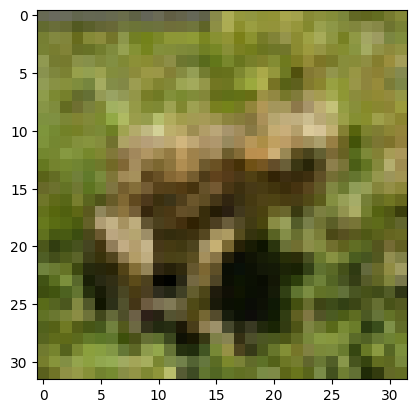

In [58]:
plt.imshow(np.transpose((images[0] + 1) /2, (1,2,0)))
plt.show()

# Convs example

In [59]:
conv_1 = nn.Conv2d(3, 10, kernel_size = 3)
                # (filter channels, how many filter is used, filter size)

conv_1_out = conv_1(images)         # image = [3, 32, 32]
                                    # conv_1_out = [10, 30, 30] (32 - 3)/ 1 + 1 = 30

print(conv_1_out.size())

torch.Size([64, 10, 30, 30])


In [60]:
conv_2 = nn.Conv2d(3, 5, kernel_size = 5)

conv_2_out = conv_2(images)         # conv_2_out = [5, 28, 28]

print(conv_2_out.size())

torch.Size([64, 5, 28, 28])


In [61]:
conv_3 = nn.Conv2d(3, 5, kernel_size = 3, stride = 1)

conv_3_out = conv_3(images)         # [5, 30, 30]

print(conv_3_out.size())

torch.Size([64, 5, 30, 30])


In [62]:
conv_4 = nn.Conv2d(3, 5, kernel_size = 4, stride = 2, padding = 1)

conv_4_out = conv_4(images)         # (32 - 4 + 2 * 1) / 2 + 1 = 16

print(conv_4_out.size())

torch.Size([64, 5, 16, 16])


## Exercise

In [63]:
conv1 = nn.Conv2d(3, 6, kernel_size = 5)
conv2 = nn.Conv2d(6, 16, kernel_size = 5)

In [64]:
conv_1_out = conv1(images)              # image (3, 32, 32)     -> (6, 28, 28)
conv_2_out = conv2(conv_1_out)          # (6, 28, 28)    -> (16, 24, 24)

print(conv_2_out.size())

torch.Size([64, 16, 24, 24])


# Pooling

In [65]:
pool_1 = nn.MaxPool2d(2, 2)
pool_1_out = pool_1(images)         # [64, 3, 32, 32]

print(pool_1_out.size())

torch.Size([64, 3, 16, 16])


# Design your own Network

In [66]:
conv_1 = nn.Conv2d(3, 16, kernel_size = 5)
pool_1 = nn.MaxPool2d(2, 2)
conv_2 = nn.Conv2d(16, 32, kernel_size = 5)
pool_2 = nn.MaxPool2d(2, 2)

conv1_out = conv_1(images)              # conv1_out [64, 16, 28, 28]
pool1_out = pool_1(conv1_out)           # pool1_out [64, 16, 14, 14]

conv2_out = conv_2(pool1_out)           # conv2_out [64, 32, 10, 10]
pool2_out = pool_2(conv2_out)           # pool2_out [64, 32, 5, 5]

print(pool2_out.size())

torch.Size([64, 32, 5, 5])


In [67]:
x = pool2_out.view(-1, 32 * 5 * 5)     # x [64, 800]

fc = nn.Linear(800, 10)

x = fc(x)

print(x.size())

torch.Size([64, 10])


In [68]:
class CustomNN(nn.Module):
    def __init__(self):
        super(CustomNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size = 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size = 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.fc = nn.Linear(800, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 32 * 5 * 5)
        x = self.fc(x)

        return x

In [69]:
model = CustomNN()

output = model(images).to(device)
print(output.size())

torch.Size([64, 10])


In [70]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10

for epoch in range(num_epochs):
    loss_per_epoch = 0
    for images, label in trainloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_per_epoch += loss
    print(f"epoch: {epoch}, loss_per_epoch: {loss_per_epoch}")

epoch: 0, loss_per_epoch: 1754.3206787109375
epoch: 1, loss_per_epoch: 1752.2957763671875
epoch: 2, loss_per_epoch: 1752.038818359375
epoch: 3, loss_per_epoch: 1751.82421875
epoch: 4, loss_per_epoch: 1751.57666015625
epoch: 5, loss_per_epoch: 1751.570556640625
epoch: 6, loss_per_epoch: 1751.5203857421875
epoch: 7, loss_per_epoch: 1751.5814208984375
epoch: 8, loss_per_epoch: 1751.751708984375


KeyboardInterrupt: 

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for images, label in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {correct/total}")